# Задание 11. Нейросеть и регрессия на бриллиантах

In [61]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder

from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

## Возьмите набор данных о бриллиантах с Kaggle.

https://www.kaggle.com/datasets/shivam2503/diamonds?datasetId=1312

In [14]:
diamonds_data = pd.read_csv('diamonds.csv').drop('Unnamed: 0', axis=1)  # .set_index('Unnamed: 0')
diamonds_data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Исследуйте и опишите датасет. Проведите предварительную обработку, рассмотрите несколько вариантов, например, удаление или кодирование категориальных признаков.

### Размер датасета

In [15]:
diamonds_data.shape

(53940, 10)

### Случайные строки

In [16]:
diamonds_data.sample(5, random_state=42)

,carat,cut,color,clarity,depth,table,price,x,y,z
1388,0.24,Ideal,G,VVS1,62.1,56.0,559,3.97,4.00,2.47
50052,0.58,Very Good,F,VVS2,60.0,57.0,2201,5.44,5.42,3.26
41645,0.40,Ideal,E,VVS2,62.1,55.0,1238,4.76,4.74,2.95
42377,0.43,Premium,E,VVS2,60.8,57.0,1304,4.92,4.89,2.98
17244,1.55,Ideal,E,SI2,62.3,55.0,6901,7.44,7.37,4.61


### Типы данных

In [17]:
diamonds_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


### Подсчет и удаление дубликатов

In [18]:
diamonds_data.duplicated().sum()

146

In [19]:
diamonds_data[diamonds_data.duplicated() == True]

,carat,cut,color,clarity,depth,table,price,x,y,z
1005,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1006,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1007,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1008,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
2025,1.52,Good,E,I1,57.3,58.0,3105,7.53,7.42,4.28
...,...,...,...,...,...,...,...,...,...,...
47969,0.52,Ideal,D,VS2,61.8,55.0,1919,5.19,5.16,3.20
49326,0.51,Ideal,F,VVS2,61.2,56.0,2093,5.17,5.19,3.17
49557,0.71,Good,F,SI2,64.1,60.0,2130,0.00,0.00,0.00
50079,0.51,Ideal,F,VVS2,61.2,56.0,2203,5.19,5.17,3.17


In [20]:
diamonds_data = diamonds_data.drop_duplicates()

In [21]:
diamonds_data.duplicated().sum()

0

### Подсчет пропусков

In [22]:
diamonds_data.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

Пропусков нет

### Исследование числовых признаков (зависимостей)

price price in US dollars (\$326--\$18,823)

carat weight of the diamond (0.2--5.01)

cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color diamond colour, from J (worst) to D (best)

clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

x length in mm (0--10.74)

y width in mm (0--58.9)

z depth in mm (0--31.8)

depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

table width of top of diamond relative to widest point (43--95)

In [23]:
diamonds_data.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

In [24]:
numerical_columns_and_target = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
numerical_columns = ['carat', 'depth', 'table', 'x', 'y', 'z']
categorical_columns = ['cut', 'color', 'clarity']
target_column = 'price'

In [25]:
diamonds_data[numerical_columns].describe()

,carat,depth,table,x,y,z
count,53794.00000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000
mean,0.79778,61.748080,57.458109,5.731214,5.734653,3.538714
std,0.47339,1.429909,2.233679,1.120695,1.141209,0.705037
min,0.20000,43.000000,43.000000,0.000000,0.000000,0.000000
25%,0.40000,61.000000,56.000000,4.710000,4.720000,2.910000
50%,0.70000,61.800000,57.000000,5.700000,5.710000,3.530000
75%,1.04000,62.500000,59.000000,6.540000,6.540000,4.030000
max,5.01000,79.000000,95.000000,10.740000,58.900000,31.800000


Видно, что диапазон числовых признаков очень разный, может отличаться в 2-3 раза. Поэтому при построении моделей нужно будет использовать скалирование.

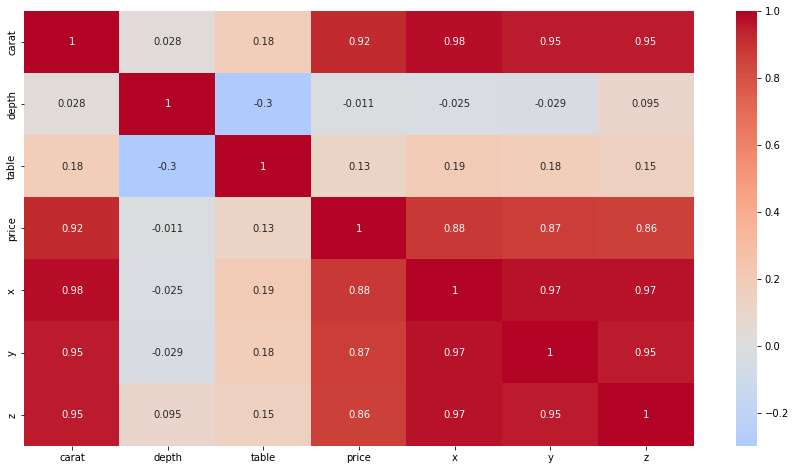

In [26]:
corr_matrix = pd.DataFrame.corr(diamonds_data[numerical_columns_and_target])
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, center=0);

Некоторые признаки практически линейно зависимы. Нужно будет их обработать.

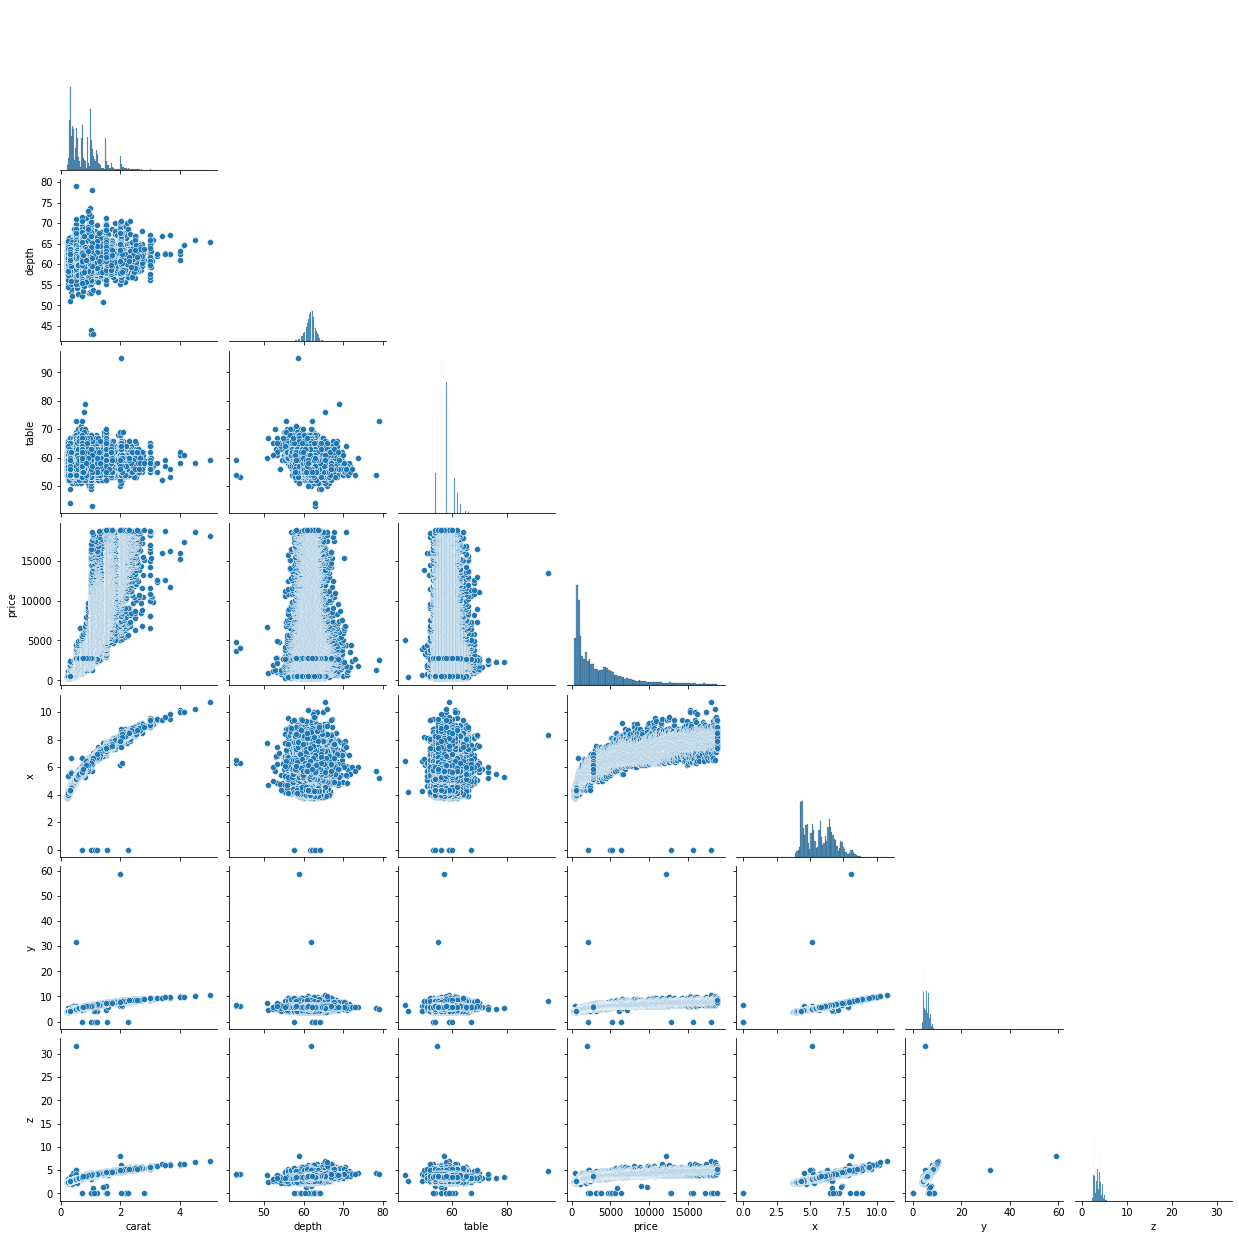

In [27]:
sns.pairplot(diamonds_data[numerical_columns_and_target], corner=True);

### Исследование отдельных признаков

In [28]:
def paint_feature(data_column, is_numerical=True, figsize_=(18, 6), colors_=['cyan', 'deeppink', 'lime', 'coral', 'yellow', 'darkorchid', 'red']):
    fig, axes = plt.subplots(1, 2, figsize=figsize_)
    axes[0].grid(True)
    if is_numerical:
        sns.histplot(ax=axes[0], x=data_column, color='cyan')
        sns.boxplot(ax=axes[1], x=data_column, color='cyan')

    else:
        data_count = data_column.value_counts()
        axes[0].bar(x=data_count.index, height=data_count.values, color=colors_);
        axes[1].pie(labels=data_count.index, x=data_count.values, colors=colors_, autopct='%1.2f%%');

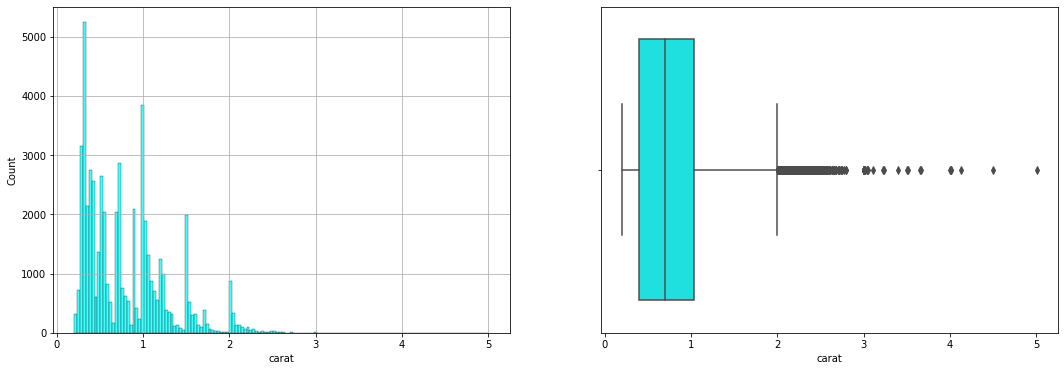

In [29]:
paint_feature(diamonds_data.carat)

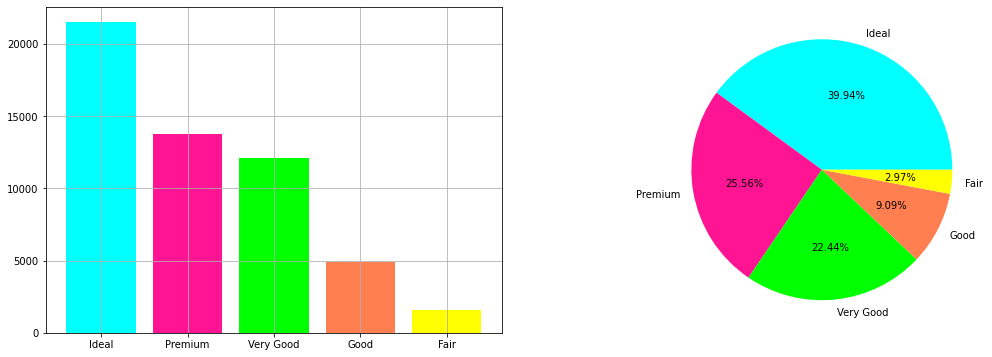

In [30]:
paint_feature(diamonds_data.cut, is_numerical=False)

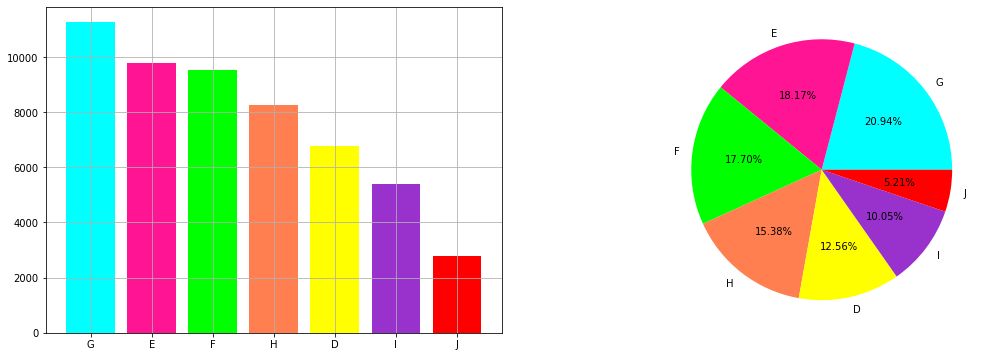

In [31]:
paint_feature(diamonds_data.color, is_numerical=False)

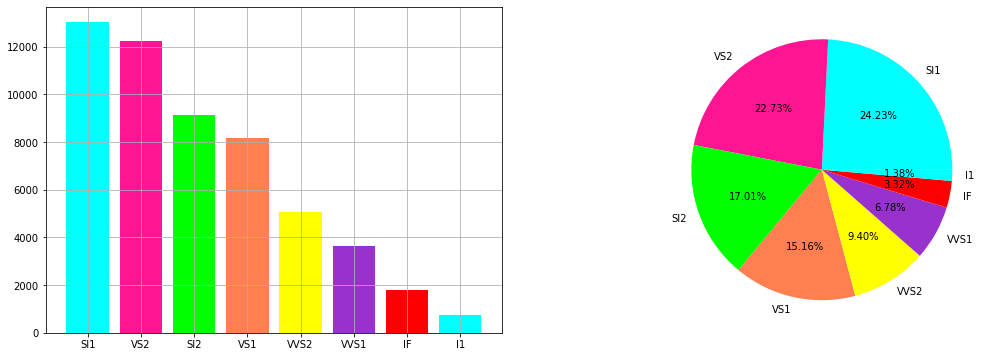

In [32]:
paint_feature(diamonds_data.clarity, is_numerical=False)

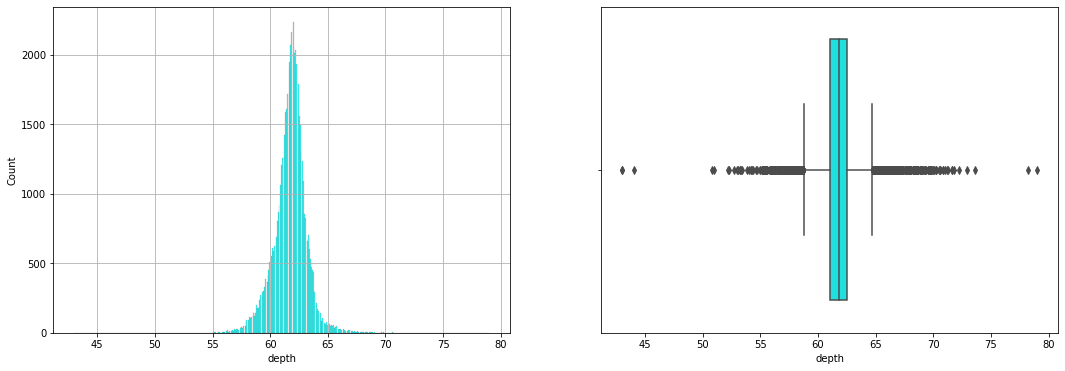

In [33]:
paint_feature(diamonds_data.depth)

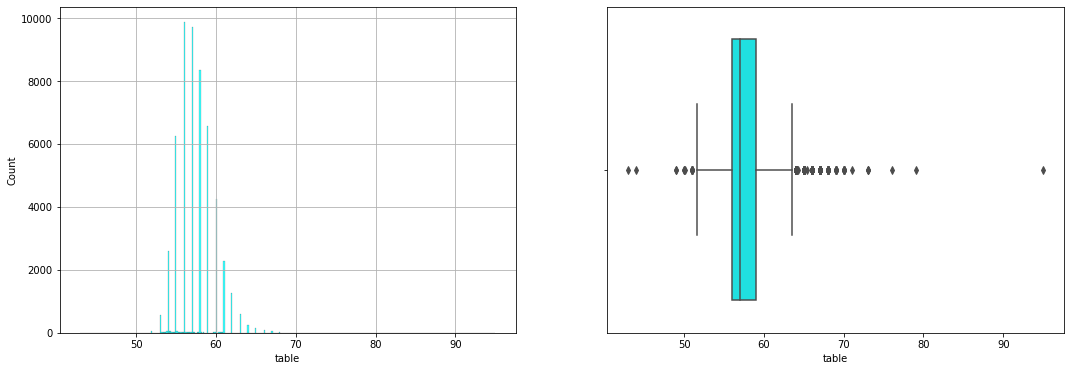

In [34]:
paint_feature(diamonds_data.table)

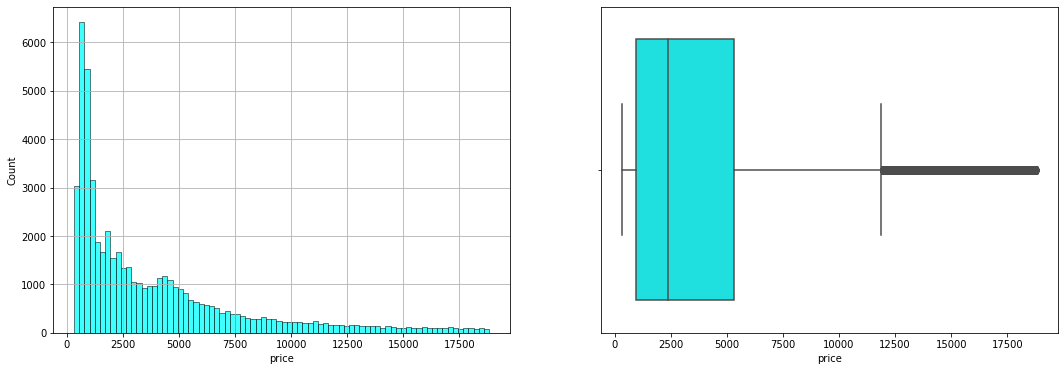

In [35]:
paint_feature(diamonds_data.price)

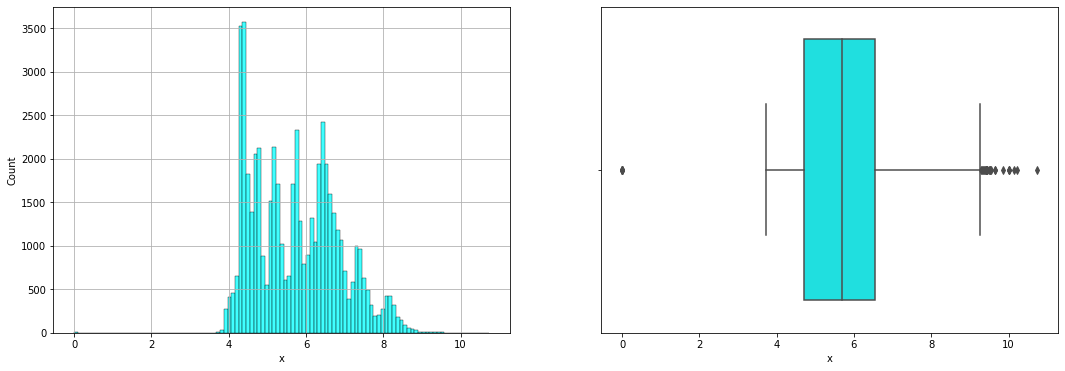

In [36]:
paint_feature(diamonds_data.x)

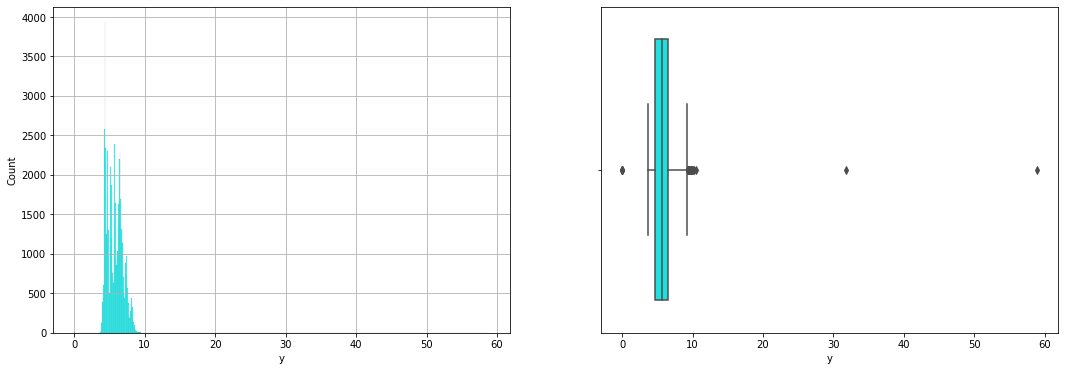

In [37]:
paint_feature(diamonds_data.y)

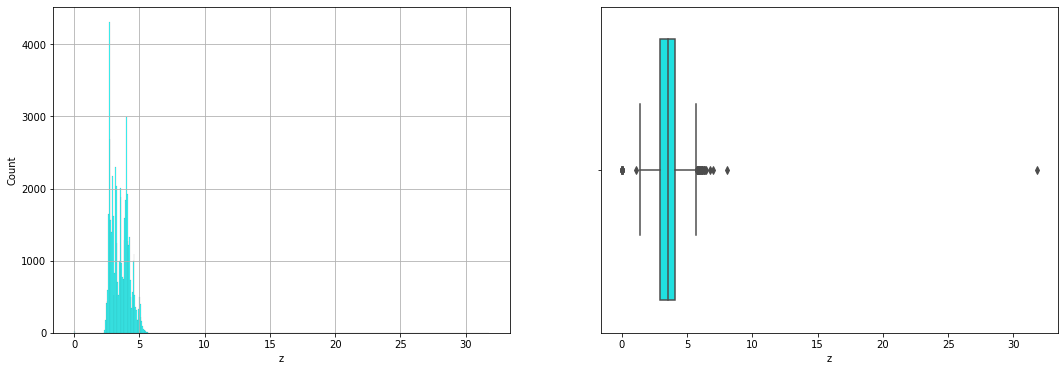

In [38]:
paint_feature(diamonds_data.z)

## Создайте и обучите MLPRegressor для предсказания цен. Сравните с другими регрессиями, в т.ч. c SGDRegressor. Оцените влияние предварительной обработки.

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html

Считывание данных и удаление дубликатов, чтобы не перезапускать ноутбук

In [39]:
diamonds_data = pd.read_csv('diamonds.csv').drop('Unnamed: 0', axis=1)  # .set_index('Unnamed: 0')
diamonds_data = diamonds_data.drop_duplicates()
diamonds_data

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


Удалим коррелирующие признаки

In [40]:
diamonds_data.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

In [41]:
diamonds_data = diamonds_data.drop(['x', 'y', 'z'], axis=1)

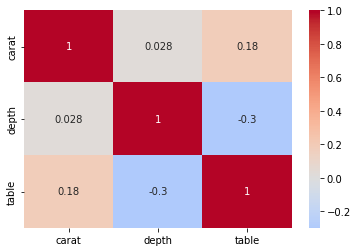

In [42]:
corr_matrix = pd.DataFrame.corr(diamonds_data[['carat', 'depth', 'table']])
# plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, center=0);

Разделим датасет на признаковые колонки и целевую. Создадим списки числовых и категориальных признаков.

In [43]:
numerical_features = ['carat', 'depth', 'table']
categorical_features = ['cut', 'color', 'clarity']
X = diamonds_data[['carat', 'depth', 'table', 'cut', 'color', 'clarity']]
y = diamonds_data['price']
display(X.head())
display(y.head())

,carat,depth,table,cut,color,clarity
0,0.23,61.5,55.0,Ideal,E,SI2
1,0.21,59.8,61.0,Premium,E,SI1
2,0.23,56.9,65.0,Good,E,VS1
3,0.29,62.4,58.0,Premium,I,VS2
4,0.31,63.3,58.0,Good,J,SI2


0    326
1    326
2    327
3    334
4    335
Name: price, dtype: int64

На примере одной колонки посмотрим работу энкодеров.

In [44]:
X.cut.unique()

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'], dtype=object)

In [45]:
X.cut[:15:]

0         Ideal
1       Premium
2          Good
3       Premium
4          Good
5     Very Good
6     Very Good
7     Very Good
8          Fair
9     Very Good
10         Good
11        Ideal
12      Premium
13        Ideal
14      Premium
Name: cut, dtype: object

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [46]:
enc = OneHotEncoder(sparse=False)
transformed_X = enc.fit_transform(X[['cut']])
transformed_X[:15:]

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html

In [47]:
enc = OrdinalEncoder()
transformed_X = enc.fit_transform(X[['cut']])
transformed_X[:15:]

array([[2.],
       [3.],
       [1.],
       [3.],
       [1.],
       [4.],
       [4.],
       [4.],
       [0.],
       [4.],
       [1.],
       [2.],
       [3.],
       [2.],
       [3.]])

Разберемся с column transformer-ом

https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

In [48]:
ct = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(), categorical_features)], sparse_threshold=0)
ct

ColumnTransformer(sparse_threshold=0,
                  transformers=[('num', StandardScaler(),
                                 ['carat', 'depth', 'table']),
                                ('cat', OneHotEncoder(),
                                 ['cut', 'color', 'clarity'])])

In [49]:
transformed_X = ct.fit_transform(X)
display(transformed_X[:5:])

array([[-1.19940227, -0.17349495, -1.10048556,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-1.2416511 , -1.36239274,  1.58569074,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-1.19940227, -3.39051249,  3.37647494,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.    

Теперь пайплайн

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [50]:
preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(), categorical_features)])
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor', LinearRegression())])
display(pipe)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['carat', 'depth', 'table']),
                                                 ('cat', OneHotEncoder(),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('regressor', LinearRegression())])

### Исследование

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [52]:
def count_metrics(y_test, y_pred_test):
  mse_test = mean_squared_error(y_true=y_test, y_pred=y_pred_test)
  mae_test = mean_absolute_error(y_true=y_test, y_pred=y_pred_test)
  mape_test = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_test)
  r2_test = r2_score(y_true=y_test, y_pred=y_pred_test)
  return mse_test, mae_test, mape_test, r2_test

#### Только кодирование

In [53]:
def make_regression_withount_scaling(X_train, X_test, y_train, y_test, 
                    methods={'LinearRegression': LinearRegression, 
                             'Lasso': Lasso, 'Ridge': Ridge,
                             'SGDRegressor': SGDRegressor, 'MLPRegressor': MLPRegressor}, 
                    encoder_=OneHotEncoder, cat_cols=categorical_features):
  metrics_list = []
  s = 20 + 12 + 12 + 10 + 10 + 6
  for i in range(s):
    print('-', end='')
  print()
  print(f'|{"regressor": >20}|{"MSE": >12}|{"MAE": >12}|{"MAPE": >10}|{"R2": >10}|')
  for i in range(s):
    print('-', end='')
  print()
  for method_name, method in methods.items():
    # scaling num features, encoding cat features
    preprocessor = ColumnTransformer(
        transformers=[('cat', encoder_(), cat_cols)], remainder='passthrough')
    # pipeline model
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', method())])
    # training model
    pipe.fit(X_train, y_train)
    # predicting
    y_pred = pipe.predict(X_test)
    # counting metrics
    cur_metr = count_metrics(y_test, y_pred)
    print(f'|{method_name: >20}|{cur_metr[0]: >12.3f}|{cur_metr[1]: >12.3f}|{cur_metr[2]: >10.7f}|{cur_metr[3]: >10.7f}|')
    
    metrics_list.append(cur_metr)
  for i in range(s):
    print('-', end='')

OneHotEncoder

In [54]:
make_regression_withount_scaling(X_train, X_test, y_train, y_test)

----------------------------------------------------------------------
|           regressor|         MSE|         MAE|      MAPE|        R2|
----------------------------------------------------------------------
|    LinearRegression| 1279480.095|     787.990| 0.4341201| 0.9160560|
|               Lasso| 1279566.111|     785.281| 0.4290891| 0.9160504|
|               Ridge| 1279514.296|     787.803| 0.4337008| 0.9160538|
|        SGDRegressor|7109514679572776.000|69621270.624|45126.0757454|-466440225.1361507|
|        MLPRegressor|  761855.515|     547.193| 0.2825656| 0.9500163|
----------------------------------------------------------------------

OrdinalEncoder

In [55]:
make_regression_withount_scaling(X_train, X_test, y_train, y_test, encoder_=OrdinalEncoder)

----------------------------------------------------------------------
|           regressor|         MSE|         MAE|      MAPE|        R2|
----------------------------------------------------------------------
|    LinearRegression| 1804499.062|     911.150| 0.4286849| 0.8816106|
|               Lasso| 1804599.252|     910.700| 0.4277261| 0.8816041|
|               Ridge| 1804514.388|     911.093| 0.4285553| 0.8816096|
|        SGDRegressor|684506000693279.000|21822184.120|13832.0924208|-44908990.4213541|
|        MLPRegressor| 1480147.771|     798.159| 0.3370971| 0.9028906|
----------------------------------------------------------------------

SGDRegressor-у становится плохо без нормализации числовых признаков.

#### Со скалированием и кодированием.

In [56]:
def make_regression(X_train, X_test, y_train, y_test, 
                    methods={'LinearRegression': LinearRegression, 
                             'Lasso': Lasso, 'Ridge': Ridge,
                             'SGDRegressor': SGDRegressor, 'MLPRegressor': MLPRegressor}, 
                    scaler_=StandardScaler, encoder_=OneHotEncoder, 
                    num_cols=numerical_features, cat_cols=categorical_features):
  metrics_list = []
  s = 20 + 12 + 12 + 10 + 10 + 6
  for i in range(s):
    print('-', end='')
  print()
  print(f'|{"regressor": >20}|{"MSE": >12}|{"MAE": >12}|{"MAPE": >10}|{"R2": >10}|')
  for i in range(s):
    print('-', end='')
  print()
  for method_name, method in methods.items():
    # scaling num features, encoding cat features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', scaler_(), num_cols),
            ('cat', encoder_(), cat_cols)])
    # pipeline model
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', method())])
    # training model
    pipe.fit(X_train, y_train)
    # predicting
    y_pred = pipe.predict(X_test)
    # counting metrics
    cur_metr = count_metrics(y_test, y_pred)
    print(f'|{method_name: >20}|{cur_metr[0]: >12.3f}|{cur_metr[1]: >12.3f}|{cur_metr[2]: >10.7f}|{cur_metr[3]: >10.7f}|')
    
    metrics_list.append(cur_metr)
  for i in range(s):
    print('-', end='')
  
  # getting results
  # metrics_df = pd.DataFrame({'LinearRegression': metrics_list[0],
  #                            'Lasso': metrics_list[1],
  #                            'Ridge': metrics_list[2],
  #                            'SGDRegressor': metrics_list[3],
  #                            'MLPRegressor': metrics_list[4],},
  #                     index=['MSE', 'MAE', 'MAPE', 'R2'])
  # return metrics_df

StandardScaler + OneHotEncoder

In [57]:
make_regression(X_train, X_test, y_train, y_test)

----------------------------------------------------------------------
|           regressor|         MSE|         MAE|      MAPE|        R2|
----------------------------------------------------------------------
|    LinearRegression| 1279480.095|     787.990| 0.4341201| 0.9160560|
|               Lasso| 1279522.126|     785.448| 0.4294710| 0.9160533|
|               Ridge| 1279417.222|     788.190| 0.4343566| 0.9160601|
|        SGDRegressor| 1280462.809|     789.866| 0.4322133| 0.9159915|
|        MLPRegressor|  498400.815|     420.660| 0.1803340| 0.9673010|
----------------------------------------------------------------------

MinMaxScaler + OneHotEncoder

In [58]:
make_regression(X_train, X_test, y_train, y_test, scaler_=MinMaxScaler)

----------------------------------------------------------------------
|           regressor|         MSE|         MAE|      MAPE|        R2|
----------------------------------------------------------------------
|    LinearRegression| 1279480.095|     787.990| 0.4341201| 0.9160560|
|               Lasso| 1281871.118|     784.884| 0.4264322| 0.9158991|
|               Ridge| 1279891.741|     786.390| 0.4304327| 0.9160290|
|        SGDRegressor| 1283712.762|     781.891| 0.4181501| 0.9157783|
|        MLPRegressor| 1262609.930|     784.994| 0.4349066| 0.9171628|
----------------------------------------------------------------------

RobustScaler + OneHotEncoder

In [62]:
make_regression(X_train, X_test, y_train, y_test, scaler_=RobustScaler)

----------------------------------------------------------------------
|           regressor|         MSE|         MAE|      MAPE|        R2|
----------------------------------------------------------------------
|    LinearRegression| 1279480.095|     787.990| 0.4341201| 0.9160560|
|               Lasso| 1279541.421|     785.400| 0.4293486| 0.9160520|
|               Ridge| 1279533.709|     787.833| 0.4337021| 0.9160525|
|        SGDRegressor| 1280236.919|     783.412| 0.4331045| 0.9160064|
|        MLPRegressor| 1166898.236|     776.336| 0.4418198| 0.9234423|
----------------------------------------------------------------------

StandardScaler + OrdinalEncoder

In [59]:
make_regression(X_train, X_test, y_train, y_test, encoder_=OrdinalEncoder)

----------------------------------------------------------------------
|           regressor|         MSE|         MAE|      MAPE|        R2|
----------------------------------------------------------------------
|    LinearRegression| 1804499.062|     911.150| 0.4286849| 0.8816106|
|               Lasso| 1804572.019|     910.822| 0.4280215| 0.8816058|
|               Ridge| 1804502.769|     911.136| 0.4286539| 0.8816104|
|        SGDRegressor| 1811973.710|     921.612| 0.4247893| 0.8811202|
|        MLPRegressor| 1054379.352|     594.828| 0.1935042| 0.9308244|
----------------------------------------------------------------------

MinMaxScaler + OrdinalEncoder

In [60]:
make_regression(X_train, X_test, y_train, y_test, scaler_=MinMaxScaler, encoder_=OrdinalEncoder)

----------------------------------------------------------------------
|           regressor|         MSE|         MAE|      MAPE|        R2|
----------------------------------------------------------------------
|    LinearRegression| 1804499.062|     911.150| 0.4286849| 0.8816106|
|               Lasso| 1807529.959|     908.753| 0.4230658| 0.8814118|
|               Ridge| 1805048.917|     909.731| 0.4254876| 0.8815746|
|        SGDRegressor| 1827596.060|     918.481| 0.4091326| 0.8800953|
|        MLPRegressor| 1685971.751|     893.291| 0.4182891| 0.8893870|
----------------------------------------------------------------------

RobustScaler + OrdinalEncoder

In [63]:
make_regression(X_train, X_test, y_train, y_test, scaler_=RobustScaler, encoder_=OrdinalEncoder)

----------------------------------------------------------------------
|           regressor|         MSE|         MAE|      MAPE|        R2|
----------------------------------------------------------------------
|    LinearRegression| 1804499.062|     911.150| 0.4286849| 0.8816106|
|               Lasso| 1804596.376|     910.762| 0.4278896| 0.8816042|
|               Ridge| 1804505.626|     911.126| 0.4286302| 0.8816102|
|        SGDRegressor| 1805816.887|     911.955| 0.4307918| 0.8815242|
|        MLPRegressor| 1119457.813|     634.755| 0.2272349| 0.9265547|
----------------------------------------------------------------------

"Места предобработки":
1. StandardScaler + OneHotEncoder
2. StandardScaler + OrdinalEncoder
3. RobustScaler + OrdinalEncoder
4. RobustScaler + OneHotEncoder
5. MinMaxScaler + OneHotEncoder
6. MinMaxScaler + OrdinalEncoder

**Выводы:**
* Самый лучший результат дает комбинация StandardScaler + OneHotEncoder + MLPRegressor
* Для StandardScaler и MinMaxScaler лучше показал себя OneHotEncoder, OrdinalEncoder значительно хуже
* Для RobustScaler оба энкодера показывают примерно одинаковые результаты, OrdinalEncoder чуть лучше, различие в $R^2$ в 3 знаке после запятой